In [275]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

pd.options.display.float_format = '{:20.2f}'.format

pd.set_option('display.max.columns', 999)

## **0. Anonymization & PII Handling**

In this project, I utilized a private, real-world dataset. To ensure client privacy, I anonymized all personally identifiable information (PII) such as names and specific business details were anonymized before this analysis began, as well as rounding specific cost amounts to the nearest whole number. The following section documents the process I used to create a clean, privacy-compliant dataset for this project.

> **Important Note:** This notebook operates on the already anonymized data file. The code below is included for documentation and demonstration of the anonymization logic.

### **Summary**

Each unique customer name was replaced with a **unique, non-identifiable anonymous ID**. For example, `Thatcher McClure` might become `CUST_0001`, and to prevent giving away the business type, I replaced service descriptions like `Oil Replacement` with a generic label like `SERVICE`. This allows for all the analysis without ever exposing the actual names or specific business details.

> **Important Note** The mapping between the real names and their anonymous IDs is stored **separately** and securely, entirely outside of my project repository, ensuring complete data privacy.

## **1. Data Exploration & Structuring**

The raw data is not in a standard tabular format. After an initial inspection, I discovered that the file is a concatenated report, containing distinct data sections. The first step of my data engineering process is to identify and separate these different entry types for targeted cleaning and aggregation.

In [276]:
df = pd.read_csv("./data/anonymized_data.csv")

df.head()

,!ACCNT,NAME,ACCNTTYPE,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7
0,ACCNT,CITY,0CLIAB,NaN,NaN,NaN,NaN,NaN
1,ACCNT,Tax Payable,OCLIAB,NaN,NaN,NaN,NaN,NaN
2,ACCNT,Income,INC,NaN,NaN,NaN,NaN,NaN
3,ACCNT,Uncategorized Income,INC,NaN,NaN,NaN,NaN,NaN
4,ACCNT,Sales,INC,NaN,NaN,NaN,NaN,NaN


In [277]:
types = df['!ACCNT'].unique() # Returns all unique values in the !ACCNT column

types

array(['ACCNT', '!CUST', 'CUST', '!TRNS', '!SPL', '!ENDTRNS', 'TRNS',
       'SPL', 'ENDTRNS'], dtype=object)

In [278]:
df.iloc[148:].head()

,!ACCNT,NAME,ACCNTTYPE,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7
148,!TRNS,TRNSID,TRNSTYPE,DATE,ACCNT,NaN,NaN,MEMO
149,!SPL,SPLID,TRNSTYPE,DATE,ACCNT,NaN,NaN,MEMO
150,!ENDTRNS,NaN,NaN,NaN,NaN,NaN,NaN,NaN
151,TRNS,NaN,GENERAL JOURNAL,1/5/2024,Accounts Receivable,OWNER,90.00,Payment for invoice #1965 - CUST_0099
152,SPL,NaN,GENERAL JOURNAL,1/5/2024,Service Income,OWNER,-90.00,Payment for invoice #1965 - CUST_0099



### **1.1. Raw Data Structure Discovered**

I identified the start of each data section by noting unique marker codes in the raw rows. Each type that starts with an '!' seems to indicate the start of a new set of data, each with a different number of columns.

* `!ACCNT`: Marks the start of the **Accounting** section (rows 0-7).

* `!CUST`: Marks the start of the **Customers** section (row 8-147).

* `!TRNS`: Marks the start of the **Transaction** section (row 148).

* `!SPL`: Marks the start of the **Split** or **Special** entries (row 149).

* `!ENDTRNS`: Marks the start of the **End Transaction** markers (row 150).

### **1.2. Interpreting the Sections**

Based on this raw structure, I was able to split the data into three distinct DataFrames for cleaning and analysis:

* **`!ACCNT` (Chart of Accounts):** This section contains a list of all the different financial accounts used. This served as a **reference table** for understanding the account types in my ledger.

* **`!CUST` (Customer Master List):** This section contains master list of customer IDs which were used for mapping the names to IDs. I used this list to create a mapping of real customer names to anonymous IDs to protect privacy.

* **`!TRNS` (Transactional Ledger):** This is the core of my analysis and contains the detailed transaction records. Within this ledger, a single invoice spans multiple rows, and I identified three primary entry types:

    * **`TRNS` (Transactions):** These rows serve as the **header** for each invoice or transaction. They contain key summary information, such as the gross amount of a payment (`Accounts Receivable`) and the primary client identifier for that transaction.

    * **`SPL` (Splits):** These rows represent **line items** that break down the total amount of a `TRNS` entry. This is where we find fine-grained details, such as the amounts allocated to `Service Income` and `Tax Payable`. These entries are essential for understanding what the service cost the client.

    * **`ENDTRNS` (End of Transaction):** These rows act as **delimiters**, marking the end of a transaction block. They are typically filled with `NaN`s and could be used to .

By separating the data into these categories, I can apply specific cleaning and aggregation rules to each type of record.

#### **Creating Distinct Dataframes**

In [279]:
df = df.rename(columns={'!ACCNT':'TYPE', 'ACCNTTYPE':'ACCOUNT_TYPE'})
accnt_df = df.iloc[0:8]
accnt_df.head()

,TYPE,NAME,ACCOUNT_TYPE,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7
0,ACCNT,CITY,0CLIAB,NaN,NaN,NaN,NaN,NaN
1,ACCNT,Tax Payable,OCLIAB,NaN,NaN,NaN,NaN,NaN
2,ACCNT,Income,INC,NaN,NaN,NaN,NaN,NaN
3,ACCNT,Uncategorized Income,INC,NaN,NaN,NaN,NaN,NaN
4,ACCNT,Sales,INC,NaN,NaN,NaN,NaN,NaN


In [280]:
cust_df = df.iloc[9:148]
cust_df.head()

,TYPE,NAME,ACCOUNT_TYPE,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7
9,CUST,CUST_0001,NaN,NaN,NaN,NaN,NaN,NaN
10,CUST,CUST_0002,NaN,NaN,NaN,NaN,NaN,NaN
11,CUST,CUST_0003,NaN,NaN,NaN,NaN,NaN,NaN
12,CUST,CUST_0004,NaN,NaN,NaN,NaN,NaN,NaN
13,CUST,CUST_0005,NaN,NaN,NaN,NaN,NaN,NaN


In [281]:
transaction_df = df.iloc[154:]
transaction_df.head()

,TYPE,NAME,ACCOUNT_TYPE,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7
154,TRNS,NaN,GENERAL JOURNAL,1/13/2024,Accounts Receivable,CUST_0099,97.00,Invoice:1965
155,SPL,NaN,GENERAL JOURNAL,1/13/2024,Tax Payable,CUST_0099,-7.00,Invoice:1965
156,SPL,NaN,GENERAL JOURNAL,1/13/2024,Service Income,CUST_0099,-90.00,Invoice:1965 SERVICE
157,ENDTRNS,NaN,NaN,NaN,NaN,NaN,NaN,NaN
158,TRNS,NaN,GENERAL JOURNAL,1/5/2024,Income,OWNER,7.00,Sales tax for invoice #1965


#### **DataFrame Examination**

In [282]:
accnt_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8 entries, 0 to 7
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   TYPE          8 non-null      object 
 1   NAME          8 non-null      object 
 2   ACCOUNT_TYPE  8 non-null      object 
 3   Unnamed: 3    0 non-null      object 
 4   Unnamed: 4    0 non-null      object 
 5   Unnamed: 5    0 non-null      object 
 6   Unnamed: 6    0 non-null      float64
 7   Unnamed: 7    0 non-null      object 
dtypes: float64(1), object(7)
memory usage: 644.0+ bytes


In [283]:
cust_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 139 entries, 9 to 147
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   TYPE          139 non-null    object 
 1   NAME          139 non-null    object 
 2   ACCOUNT_TYPE  0 non-null      object 
 3   Unnamed: 3    0 non-null      object 
 4   Unnamed: 4    0 non-null      object 
 5   Unnamed: 5    0 non-null      object 
 6   Unnamed: 6    0 non-null      float64
 7   Unnamed: 7    0 non-null      object 
dtypes: float64(1), object(7)
memory usage: 8.8+ KB


In [284]:
transaction_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2342 entries, 154 to 2495
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   TYPE          2342 non-null   object 
 1   NAME          0 non-null      object 
 2   ACCOUNT_TYPE  1649 non-null   object 
 3   Unnamed: 3    1649 non-null   object 
 4   Unnamed: 4    1649 non-null   object 
 5   Unnamed: 5    1649 non-null   object 
 6   Unnamed: 6    1649 non-null   float64
 7   Unnamed: 7    1649 non-null   object 
dtypes: float64(1), object(7)
memory usage: 146.5+ KB


In [285]:
transaction_df.describe()

,Unnamed: 6
count,1649.00
mean,0.00
std,1778.77
min,-24125.00
25%,-125.00
50%,-8.00
75%,95.00
max,26115.00


#### **Specific Examinations**
* Negative Numbers 

* ACCOUNT_TYPE and what its associated with

In [286]:
transaction_df[transaction_df['Unnamed: 6'] < 0].head() # Checking the negatives in the price related column

,TYPE,NAME,ACCOUNT_TYPE,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7
155,SPL,NaN,GENERAL JOURNAL,1/13/2024,Tax Payable,CUST_0099,-7.00,Invoice:1965
156,SPL,NaN,GENERAL JOURNAL,1/13/2024,Service Income,CUST_0099,-90.00,Invoice:1965 SERVICE
159,SPL,NaN,GENERAL JOURNAL,1/5/2024,CITY,OWNER,-7.00,Sales tax for invoice #1965
162,SPL,NaN,GENERAL JOURNAL,1/5/2024,Service Income,OWNER,-90.00,Payment for invoice #1966 - CUST_0034
165,SPL,NaN,GENERAL JOURNAL,1/13/2024,Tax Payable,CUST_0034,-7.00,Invoice:1966


#### **Account Types Examination**

In [287]:
transaction_df['Unnamed: 4'].unique() # Returns all unique values in row 'Unnamed: 4'

array(['Accounts Receivable', 'Tax Payable', 'Service Income', nan,
       'Income', 'CITY', 'Uncategorized Income', 'Sales'], dtype=object)

In [288]:
transaction_df[transaction_df['Unnamed: 4'] == 'Accounts Receivable'].head() # This line was used determine what each account type meant

,TYPE,NAME,ACCOUNT_TYPE,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7
154,TRNS,NaN,GENERAL JOURNAL,1/13/2024,Accounts Receivable,CUST_0099,97.00,Invoice:1965
161,TRNS,NaN,GENERAL JOURNAL,1/5/2024,Accounts Receivable,OWNER,90.00,Payment for invoice #1966 - CUST_0034
164,TRNS,NaN,GENERAL JOURNAL,1/13/2024,Accounts Receivable,CUST_0034,97.00,Invoice:1966
171,TRNS,NaN,GENERAL JOURNAL,1/6/2024,Accounts Receivable,OWNER,100.00,Payment for invoice #1969 - CUST_0019
174,TRNS,NaN,GENERAL JOURNAL,1/16/2024,Accounts Receivable,CUST_0019,108.00,Invoice:1969


### **1.3. Account Types**

In my data engineering process, I analyzed each account type to determine if its associated amount should be **included** or **excluded** when calculating a customer's `MonetaryValue`. This ensures my analysis is based on actual revenue from services, not on pass-through costs or internal adjustments.

* **__Exclude:__ Accounts Receivable**
    * **Reason:** This account holds the total gross amount of an invoice, including tax. I chose to use the **`Service Income`** amount instead because it's a cleaner measure of the revenue from the service itself, excluding tax.

* **__Exclude:__ Tax Payable**
    * **Reason:** This represents money collected for tax that the business owes to the government. It is a pass-through cost and does not contribute to the business's revenue.

* **__Include:__ Service Income**
    * **Reason:** This account gives the total net revenue earned directly from a service. Its amount provides the ideal value for calculating a customer's `MonetaryValue` for segmentation.

* **__Exclude:__ Income**
    * **Reason:** While a revenue account, this is typically used for general income or specific adjustments (e.g., sales tax income). `Service Income` is a more specific and reliable measure of revenue from client services.

* **__Exclude:__ CITY**
    * **Reason:** This entity identifies a specific city to which tax money is allocated. It is an internal accounting entity and not a paying customer.

* **__Exclude:__ Uncategorized Income**
    * **Reason:** This account is used for money received that has not yet been assigned a specific revenue category. Its unclassified nature makes it unreliable for meaningful segmentation.

* **__Exclude:__ Sales**
    * **Reason:** A general revenue account similar to `Income` and `Service Income`. I chose to focus on the more specific `Service Income` to ensure the `MonetaryValue` is tied directly to services rendered.

* **__Exclude:__ `NaN`**
    * **Reason:** A `NaN` in a ledger row can indicate truly missing data or act as a **delimiter** for the `ENDTRNS` transaction marker. It has no associated value for analysis.

## **2. Data Cleaning & Preprocessing**

Based on my initial exploration, the raw data extensive cleaning and engineering to be suitable for analysis and modeling. The columns contain a mix of data types, missing values, and inconsistent formatting. In this section, I will transform the raw data into a clean, structured, and consistent format.

### **2.1. Structuring the Data**

After splitting the raw data into three distinct sections, the next step is to structure each DataFrame. This involves dropping columns that are completely null and renaming the remaining columns to give them clear, descriptive names.


In [289]:
accnt_df = accnt_df.reset_index()
accnt_df = accnt_df[['TYPE', 'NAME', 'ACCOUNT_TYPE']]
accnt_df.head()

,TYPE,NAME,ACCOUNT_TYPE
0,ACCNT,CITY,0CLIAB
1,ACCNT,Tax Payable,OCLIAB
2,ACCNT,Income,INC
3,ACCNT,Uncategorized Income,INC
4,ACCNT,Sales,INC


In [290]:
cust_df = cust_df.reset_index()
cust_df = cust_df[['TYPE', 'NAME']]
cust_df.rename(columns={'NAME':'ID'})
cust_df.head()

,TYPE,NAME
0,CUST,CUST_0001
1,CUST,CUST_0002
2,CUST,CUST_0003
3,CUST,CUST_0004
4,CUST,CUST_0005


In [291]:
transaction_df = transaction_df.reset_index()
transaction_df = transaction_df.drop(['NAME', 'index'], axis=1)
transaction_df = transaction_df.rename(columns={'ACCOUNT_TYPE':'JOURNAL_TYPE','Unnamed: 3':'DATE', 'Unnamed: 4':'ACCOUNT_TYPE', 'Unnamed: 5':'PRIMARY_ENTITY','Unnamed: 6':'PRICE', 'Unnamed: 7':'DESCRIPTION'})
transaction_df = transaction_df.drop(['JOURNAL_TYPE'],axis=1)
transaction_df.head()

,TYPE,DATE,ACCOUNT_TYPE,PRIMARY_ENTITY,PRICE,DESCRIPTION
0,TRNS,1/13/2024,Accounts Receivable,CUST_0099,97.00,Invoice:1965
1,SPL,1/13/2024,Tax Payable,CUST_0099,-7.00,Invoice:1965
2,SPL,1/13/2024,Service Income,CUST_0099,-90.00,Invoice:1965 SERVICE
3,ENDTRNS,NaN,NaN,NaN,NaN,NaN
4,TRNS,1/5/2024,Income,OWNER,7.00,Sales tax for invoice #1965


### **2.2. Creating a Single Cleaned DataFrame**

In order to create my customer purchase data, I need to isolate the purchases from the rest of the bookkeeping ledger. I will filter the `transaction_df` to include only rows that are directly related to client-facing transactions and revenue generation.

I will perform this filtering by focusing on `Service Income` account type that is associated with the revenue earned by the `OWNER`. This ensures my analysis is based solely on valid client purchases and excludes internal adjustments or expenses.

In [292]:
cleaned_df = transaction_df.copy()

In [293]:
cleaned_df = cleaned_df[cleaned_df['ACCOUNT_TYPE'] == 'Service Income'] # Only includes the rows with the ACCOUNT_TYPE of 'Service Income'
cleaned_df = cleaned_df[cleaned_df['PRIMARY_ENTITY'] != 'OWNER'] # Excludes the non-customer entity of 'OWNER'

In [294]:
cleaned_df['PRICE'] = cleaned_df['PRICE'] * -1 # Keeps all prices positive
cleaned_df = cleaned_df.rename(columns={'PRIMARY_ENTITY':'CUSTOMER_ID'})
cleaned_df['DATE'] = pd.to_datetime(cleaned_df['DATE']) # Changes raw string dates into datetime
cleaned_df.head()

,TYPE,DATE,ACCOUNT_TYPE,CUSTOMER_ID,PRICE,DESCRIPTION
2,SPL,2024-01-13,Service Income,CUST_0099,90.00,Invoice:1965 SERVICE
12,SPL,2024-01-13,Service Income,CUST_0034,90.00,Invoice:1966 SERVICE
22,SPL,2024-01-16,Service Income,CUST_0019,100.00,Invoice:1969 SERVICE
32,SPL,2024-01-16,Service Income,CUST_0018,90.00,Invoice:1970 SERVICE
33,SPL,2024-01-16,Service Income,CUST_0018,100.00,Invoice:1970 SERVICE


## **3. Feature Engineering**

Feature engineering is the process of creating new, powerful features from raw data to improve model performance and derive deeper insights. Now that I have a clean DataFrame of my individual transactions, I will aggregate the data to create a single customer profile based on the **RFM framework**.

The RFM framework provides three core metrics that I will calculate for each customer:

* **MonetaryValue:** The total revenue generated from a customer, calculated by summing all `Service Income` amounts associated with their transactions.

* **Frequency:** The number of unique invoices a customer has paid within the analyzed time period, which represents their engagement and loyalty.

* **Recency:** The number of days between the last transaction in the dataset and a customer's last purchase date.

In [295]:
# extracts the first 4 digits or invoice id in 'DESCRIPTION'
cleaned_df['INVOICE_ID'] = cleaned_df['DESCRIPTION'].astype(str).str.extract(r'Invoice:(\d{4})')

In [296]:
# Creates the aggreggate data for the customer profiles
aggregated_df = cleaned_df.groupby(by='CUSTOMER_ID', as_index=False) \
  .agg(
    MonetaryValue=('PRICE', 'sum'),
    Frequency=('INVOICE_ID', 'count'),
    LastInvoiceDate=('DATE', 'max')
  ) 
aggregated_df.head()

,CUSTOMER_ID,MonetaryValue,Frequency,LastInvoiceDate
0,CUST_0001,1490.00,2,2024-03-19
1,CUST_0002,190.00,3,2024-07-23
2,CUST_0003,4920.00,1,2024-02-15
3,CUST_0004,1175.00,2,2024-10-19
4,CUST_0005,2490.00,1,2024-10-27


In [297]:
last_invoice_date = aggregated_df["LastInvoiceDate"].max() # Returns the most recent invoice date

aggregated_df["Recency"] = (last_invoice_date - aggregated_df['LastInvoiceDate']).dt.days # Creates a column for the total days since last purchase
aggregated_df.head()

,CUSTOMER_ID,MonetaryValue,Frequency,LastInvoiceDate,Recency
0,CUST_0001,1490.00,2,2024-03-19,312
1,CUST_0002,190.00,3,2024-07-23,186
2,CUST_0003,4920.00,1,2024-02-15,345
3,CUST_0004,1175.00,2,2024-10-19,98
4,CUST_0005,2490.00,1,2024-10-27,90


## **4. Exploratory Data Analysis (EDA)**

With my customer profiles aggregated, I will now perform Exploratory Data Analysis to understand the distributions of my newly engineered features (Recency, Frequency, and MonetaryValue). This step is important for identifying outliers and looking for potential patterns before applying my clustering algorithm.

### **4.1. Distribution Analysis**

I began by visualizing the raw distributions of each feature using histograms and boxplots. This initial analysis helped me to identify the skewness and the presence of extreme outliers, which can heavily impact distance-based clustering algorithms.

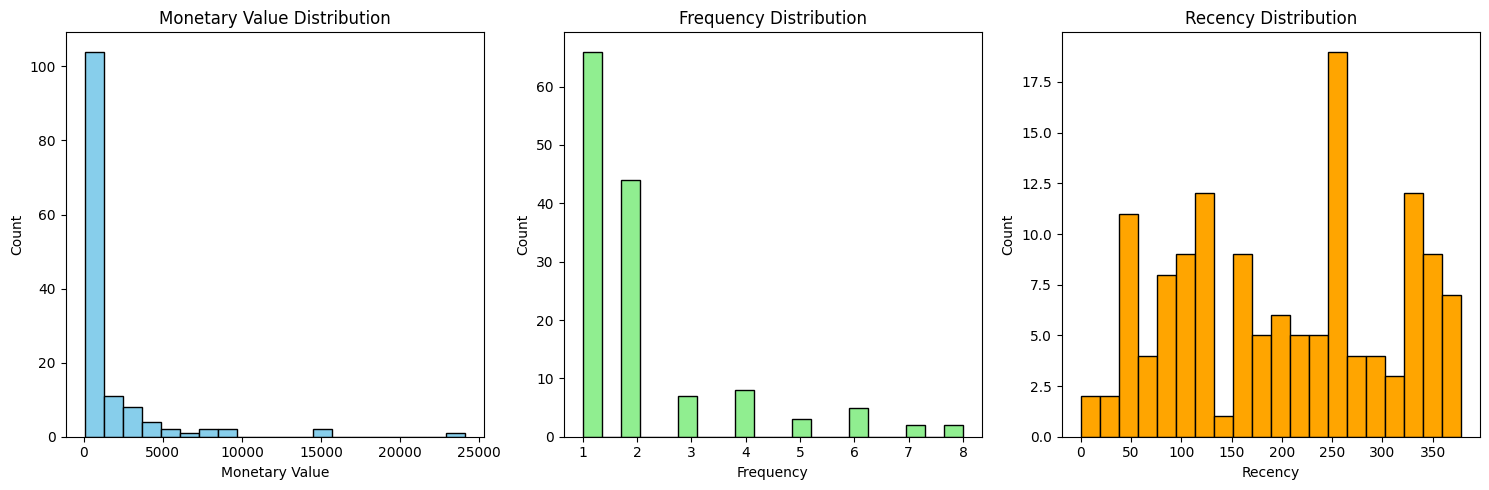

In [298]:
plt.figure(figsize=(15,5))

plt.subplot(1, 3, 1)
plt.hist(aggregated_df['MonetaryValue'], bins=20, color='skyblue', edgecolor='black')
plt.title('Monetary Value Distribution')
plt.xlabel('Monetary Value')
plt.ylabel('Count')

plt.subplot(1, 3, 2)
plt.hist(aggregated_df['Frequency'], bins=20, color='lightgreen', edgecolor='black')
plt.title('Frequency Distribution')
plt.xlabel('Frequency')
plt.ylabel('Count')

plt.subplot(1, 3, 3)
plt.hist(aggregated_df['Recency'], bins=20, color='orange', edgecolor='black')
plt.title('Recency Distribution')
plt.xlabel('Recency')
plt.ylabel('Count')

plt.tight_layout()
plt.show()

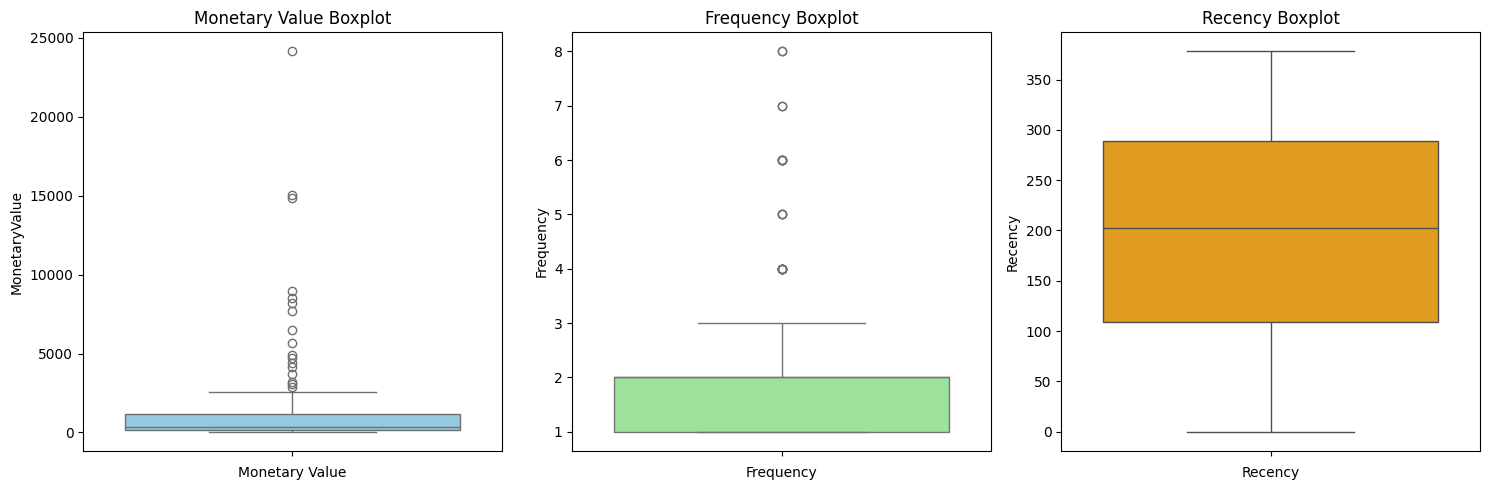

In [299]:
plt.figure(figsize=(15,5))

plt.subplot(1, 3, 1)
sns.boxplot(aggregated_df['MonetaryValue'], color='skyblue')
plt.title('Monetary Value Boxplot')
plt.xlabel('Monetary Value')

plt.subplot(1, 3, 2)
sns.boxplot(aggregated_df['Frequency'], color='lightgreen')
plt.title('Frequency Boxplot')
plt.xlabel('Frequency')

plt.subplot(1, 3, 3)
sns.boxplot(aggregated_df['Recency'], color='orange')
plt.title('Recency Boxplot')
plt.xlabel('Recency')

plt.tight_layout()
plt.show()

### **4.2. Handling Outliers**

Based on my distribution plots, I identified a number of extreme outliers in my MonetaryValue and Frequency features. These outliers could cause significant skewing in the distance-based algorithm of K-Means clustering, distorting the segmentation of the core customer base.

To address this, I chose to separate these outlier data points into their own DataFrame for later analysis.

> **Important Insight:** Remember, while these are mathematical outliers, these data points often represent our **most valuable customers**, such as major corporate clients or large one-time purchases. I will analyze them as a distinct segment later in the project.

In [300]:
MV_Q1 = aggregated_df["MonetaryValue"].quantile(0.25) # Returns the value at the first quartile
MV_Q3 = aggregated_df["MonetaryValue"].quantile(0.75) # Returns the value at the third quartile
MV_IQR = MV_Q3 - MV_Q1

# Only includes values that are within the Monetary Value's interquartile range
MV_outliers_df = aggregated_df[(aggregated_df["MonetaryValue"] > (MV_Q3 + 1.5 * MV_IQR)) | (aggregated_df["MonetaryValue"] < (MV_Q1 - 1.5 * MV_IQR))].copy()
MV_outliers_df.describe()

,MonetaryValue,Frequency,LastInvoiceDate,Recency
count,17.00,17.00,17,17.00
mean,7673.06,3.59,2024-09-05 19:45:52.941176576,141.18
min,2875.00,1.00,2024-01-27 00:00:00,7.00
25%,4155.00,2.00,2024-08-20 00:00:00,64.00
50%,5650.00,4.00,2024-09-27 00:00:00,120.00
75%,8485.00,5.00,2024-11-22 00:00:00,158.00
max,24125.00,8.00,2025-01-18 00:00:00,364.00
std,5609.95,2.18,NaN,106.75


In [301]:
F_Q1 = aggregated_df["Frequency"].quantile(0.25)
F_Q3 = aggregated_df["Frequency"].quantile(0.75) 
F_IQR = F_Q3 - F_Q1

# Only includes values that are within the Frequency's interquartile range
F_outliers_df = aggregated_df[(aggregated_df["Frequency"] > (F_Q3 + 1.5 * F_IQR)) | (aggregated_df["Frequency"] < (F_Q1 - 1.5 * F_IQR))].copy()
F_outliers_df.describe()

,MonetaryValue,Frequency,LastInvoiceDate,Recency
count,20.00,20.00,20,20.00
mean,4936.35,5.35,2024-10-15 06:00:00,101.75
min,530.00,4.00,2024-07-07 00:00:00,0.00
25%,1218.75,4.00,2024-08-24 12:00:00,54.75
50%,2235.00,5.00,2024-10-18 00:00:00,99.00
75%,6921.25,6.00,2024-12-01 06:00:00,153.50
max,24125.00,8.00,2025-01-25 00:00:00,202.00
std,5892.02,1.39,NaN,61.70


In [302]:
# Excludes values in either the Monetary Value's or Frequency's outlier DataFrames
non_outliers_df = aggregated_df[(~aggregated_df.index.isin(MV_outliers_df.index)) & (~aggregated_df.index.isin(F_outliers_df.index))]

non_outliers_df.describe()

,MonetaryValue,Frequency,LastInvoiceDate,Recency
count,109.00,109.00,109,109.00
mean,495.82,1.49,2024-06-18 00:00:00,221.00
min,50.00,1.00,2024-01-13 00:00:00,36.00
25%,140.00,1.00,2024-03-25 00:00:00,124.00
50%,295.00,1.00,2024-05-21 00:00:00,249.00
75%,585.00,2.00,2024-09-23 00:00:00,306.00
max,2590.00,3.00,2024-12-20 00:00:00,378.00
std,592.64,0.60,NaN,100.54


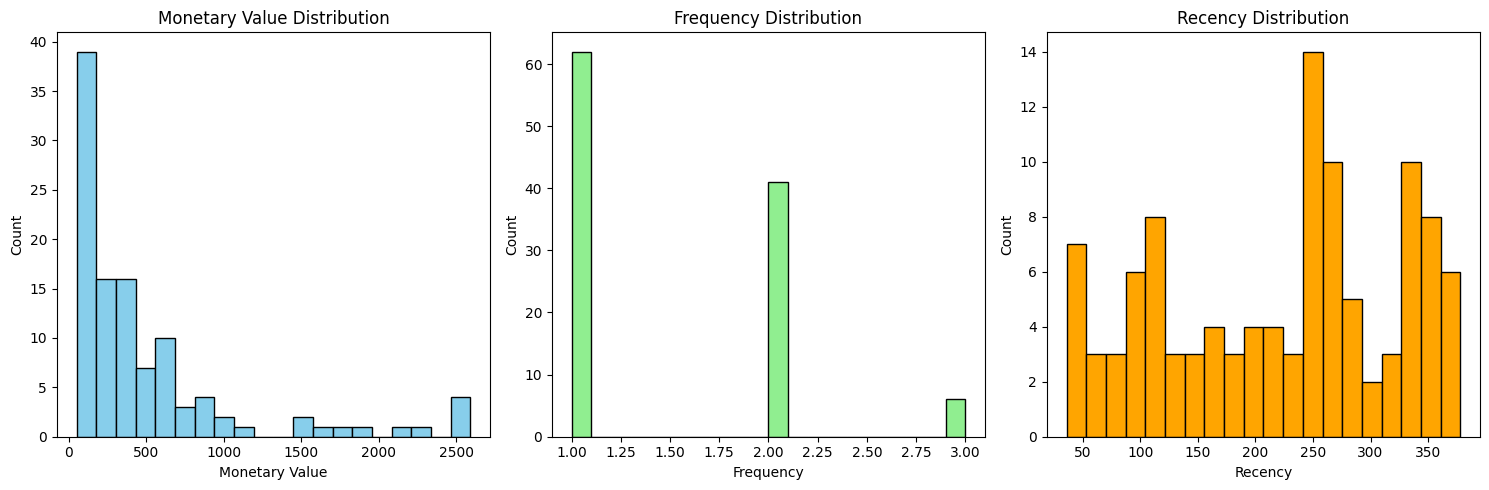

In [303]:
plt.figure(figsize=(15,5))

plt.subplot(1, 3, 1)
plt.hist(non_outliers_df['MonetaryValue'], bins=20, color='skyblue', edgecolor='black')
plt.title('Monetary Value Distribution')
plt.xlabel('Monetary Value')
plt.ylabel('Count')

plt.subplot(1, 3, 2)
plt.hist(non_outliers_df['Frequency'], bins=20, color='lightgreen', edgecolor='black')
plt.title('Frequency Distribution')
plt.xlabel('Frequency')
plt.ylabel('Count')

plt.subplot(1, 3, 3)
plt.hist(non_outliers_df['Recency'], bins=20, color='orange', edgecolor='black')
plt.title('Recency Distribution')
plt.xlabel('Recency')
plt.ylabel('Count')

plt.tight_layout()
plt.show()

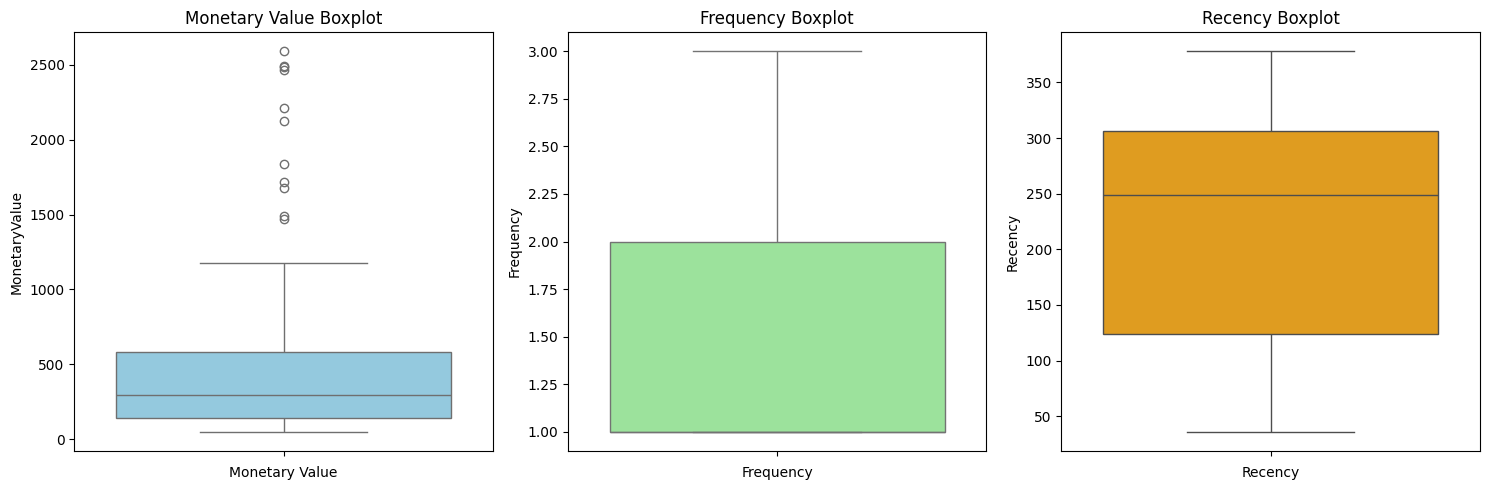

In [304]:
plt.figure(figsize=(15,5))

plt.subplot(1, 3, 1)
sns.boxplot(non_outliers_df['MonetaryValue'], color='skyblue')
plt.title('Monetary Value Boxplot')
plt.xlabel('Monetary Value')

plt.subplot(1, 3, 2)
sns.boxplot(non_outliers_df['Frequency'], color='lightgreen')
plt.title('Frequency Boxplot')
plt.xlabel('Frequency')

plt.subplot(1, 3, 3)
sns.boxplot(non_outliers_df['Recency'], color='orange')
plt.title('Recency Boxplot')
plt.xlabel('Recency')

plt.tight_layout()
plt.show()

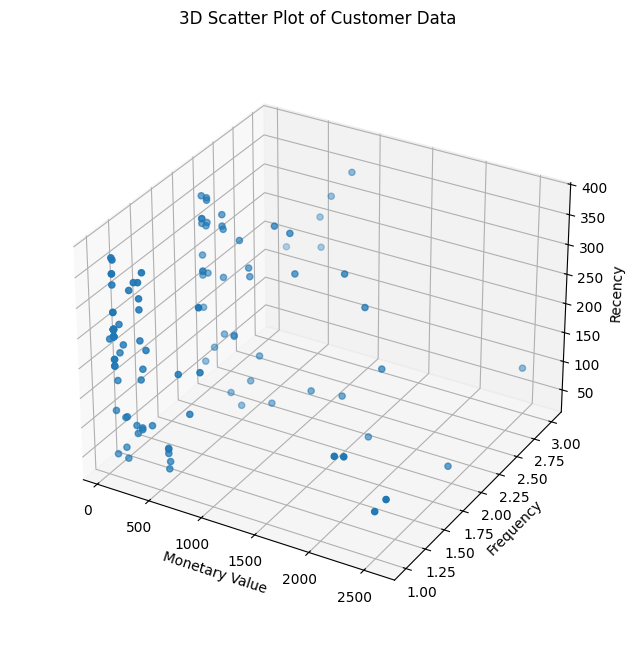

In [305]:
fig = plt.figure(figsize=(8, 8))

ax = fig.add_subplot(projection="3d")

scatter = ax.scatter(non_outliers_df["MonetaryValue"], non_outliers_df["Frequency"], non_outliers_df["Recency"])

ax.set_xlabel("Monetary Value")
ax.set_ylabel("Frequency")
ax.set_zlabel("Recency")

ax.set_title("3D Scatter Plot of Customer Data")
ax.set_box_aspect(None, zoom=0.90)
plt.show()

### **4.3. Feature Scaling**

In order for the K-Means distance-based algorithm to work effectively, I have to make sure that each feature contributes equally to the analysis. I will use **Standard Scaling** to transform or 'equaluze' my features so they are all on the same scale.

#### Formula: $Z = \frac{x - \mu}{\sigma}$

* $Z$: the standardized value
* $x$: the original value
* $\mu$: the mean of the feature
* $\sigma$: the standard deviation of the feature

#### **Layman's Terms: The Fair Playing Field**

When distance between data points becomes important in a model, we want our distances to be "fair". Consider two points: their `MonetaryValue` could have a difference of `$500`, while their `Frequency` might only have a difference of `10`. If we don't scale the data, the algorithm would incorrectly see the `$500` difference as **50 times more important** than the difference of `10`.

However, when I see that a `Frequency` difference of 10 is close to 80% of that feature's entire range, while a `MonetaryValue` difference of $500 is only 20% of its range, it becomes clear that the raw numbers would significantly skew my data. Standard Scaling solves this by ensuring that a large difference in one feature is treated with the same importance as a large difference in another, creating a level playing field for the algorithm.







In [306]:
scaler = StandardScaler() 

scaled_data = scaler.fit_transform(non_outliers_df[["MonetaryValue", "Frequency", "Recency"]])

scaled_data


array([[ 1.68529737,  0.85638525,  0.9092837 ],
       [-0.51840709,  2.52327797, -0.3497245 ],
       [ 1.15132283,  0.85638525, -1.22903181],
       [ 3.38045465, -0.81050747, -1.30896884],
       [ 0.15118004, -0.81050747, -1.3289531 ],
       [-0.68792282, -0.81050747,  0.38969301],
       [-0.5099313 , -0.81050747, -1.71864611],
       [ 2.07518354,  0.85638525, -1.72863824],
       [-0.2641335 ,  0.85638525, -0.68945687],
       [-0.23023035, -0.81050747, -0.11990554],
       [ 0.0494706 ,  2.52327797,  0.32974024],
       [-0.10309356, -0.81050747, -1.02918924],
       [-0.75572911, -0.81050747,  0.21982683],
       [-0.68792282, -0.81050747,  1.12911053],
       [-0.51840709,  0.85638525,  1.5387878 ],
       [-0.67097124, -0.81050747,  1.5387878 ],
       [-0.17089985, -0.81050747,  0.2098347 ],
       [ 0.68515458, -0.81050747,  0.10991341],
       [ 0.00709167,  0.85638525,  0.9792286 ],
       [-0.68792282, -0.81050747,  0.39968514],
       [ 0.89704924,  0.85638525,  0.679

In [307]:
scaled_data_df = pd.DataFrame(scaled_data, index=non_outliers_df.index, columns=("MonetaryValue", "Frequency", "Recency"))

scaled_data_df.head()

,MonetaryValue,Frequency,Recency
0,1.69,0.86,0.91
1,-0.52,2.52,-0.35
3,1.15,0.86,-1.23
4,3.38,-0.81,-1.31
5,0.15,-0.81,-1.33


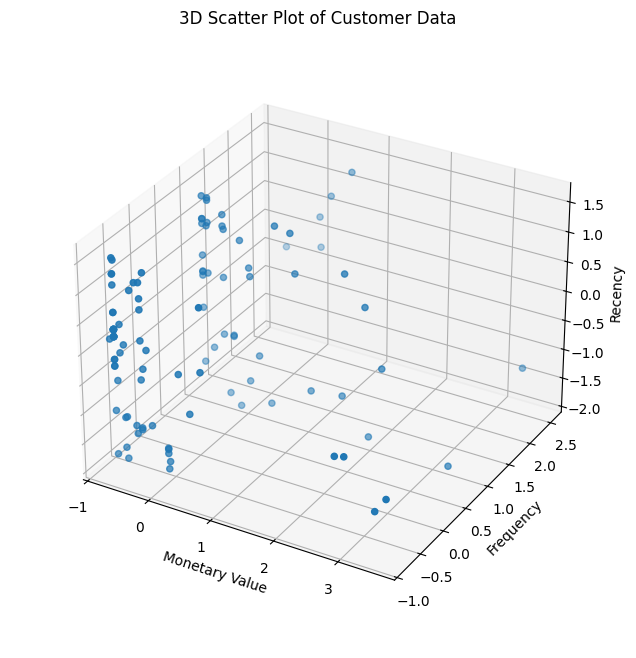

In [308]:
fig = plt.figure(figsize=(8, 8))

ax = fig.add_subplot(projection="3d")

scatter = ax.scatter(scaled_data_df["MonetaryValue"], scaled_data_df["Frequency"], scaled_data_df["Recency"])

ax.set_xlabel("Monetary Value")
ax.set_ylabel("Frequency")
ax.set_zlabel("Recency")

ax.set_title("3D Scatter Plot of Customer Data")
ax.set_box_aspect(None, zoom=0.90)
plt.show()

## **5. K-Means Clustering**

Now that my features are scaled and on a level playing field, I will apply the K-Means clustering algorithm to identify distinct customer segments. This unsupervised machine learning technique groups data points into a specified number of clusters (`k`) based on their similarities.

### **5.1. Determining the Optimal Number of Clusters (k)**

Based on the **Elbow Method** plot, I identified a clear inflection point, or 'elbow,' at `k=4`. This indicated that adding more than four clusters would provide diminishing returns in terms of internal coherence.

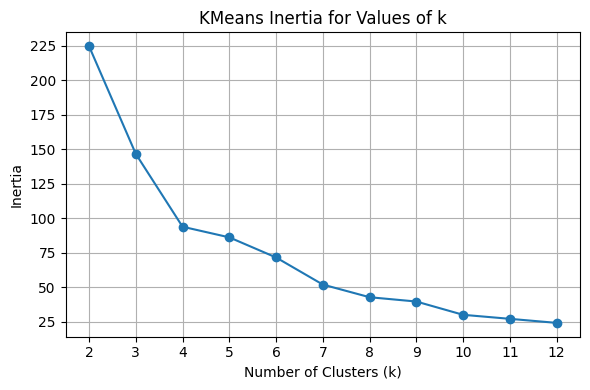

In [309]:
max_k = 12

inertia = []
silhoutte_scores = []
k_values = range(2, max_k + 1)

for k in k_values: # For each number of clusters up to 12 clusters

  kmeans = KMeans(n_clusters=k, random_state=10, max_iter=1000) # Create a KMeans instance for k number of clusters

  cluster_labels = kmeans.fit_predict(scaled_data_df) # Trains the current model on the scaled data and assigns each point a label (e.g., 0, 1, 2)

  sil_score = silhouette_score(scaled_data_df, cluster_labels) # Calculates the silhouette score for the clustering result of the current run

  silhoutte_scores.append(sil_score) # Appends that score for our line graph later 

  inertia.append(kmeans.inertia_)# Appends the inertia for our line graph later

# Graphs the silhouette score values for (k)
plt.figure(figsize=(6, 4))

plt.plot(k_values, inertia, marker='o')
plt.title("KMeans Inertia for Values of k")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Inertia")
plt.xticks(k_values)
plt.grid(True)

plt.tight_layout()
plt.show()

### **5.2 Optimal Number of Clusters (k)**

Typically, inertia data can show a tossup between 2 or more choices for what k should be. In an effort to be precise I will use **Silhouette Score**.

#### **Silhouette Score**

To measure the quality of our clusters, we use the Silhouette Score. This metric evaluates how well-defined and separated our clusters are. For each data point, it measures both its cohesion (how close it is to points in its own cluster) and its separation (how far it is from points in other clusters).

#### $s(i) =\frac{b(i) - a(i)}{max( a(i), b(i) )}$

* $s(i)$ is the silhoutte score for a single sample $i$
* $a(i)$ is the average distance between $i$ and all other points in the same cluster
* $b(i)$ is the minimum average distance between $i$ and all points in the nearest cluster to which $i$ does not belong

The Silhouette Score ranges between -1 and +1, where a higher value indicates more distinct clusters.

##### Layman's Terms:

This tells us how distinct and well-separated our clusters are. A higher value is better and shows that there isn't much overlap.

* **A score close to +1:** The clusters are dense and well-separated. A data point is very close to its own cluster and very far from any other cluster.

* **A score close to 0:** The clusters are overlapping. A data point is roughly equally close to its own cluster and a neighboring cluster, meaning it's on the fence.
* **A score close to -1:** The clustering is poor. A data point is actually closer to a different cluster than it is to its own assigned cluster, suggesting it was placed in the wrong group.

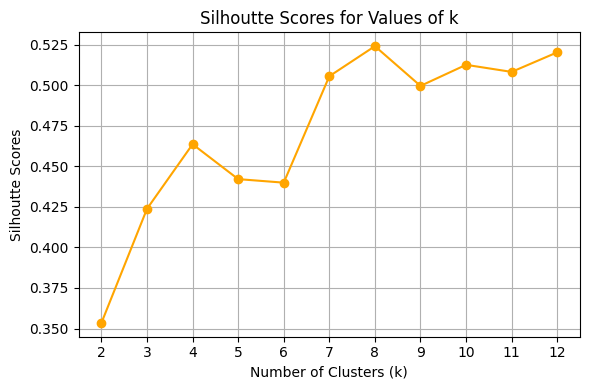

In [310]:
# Graphs the inertia values for (k)
plt.figure(figsize=(6, 4))
plt.plot(k_values, silhoutte_scores, marker='o', color='orange')
plt.title("Silhoutte Scores for Values of k")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Silhoutte Scores")
plt.xticks(k_values)
plt.grid(True)

plt.tight_layout()
plt.show()

In [311]:
# With our final choice of (k), create an instance of KMeans for the clustering algorithm
kmeans = KMeans(n_clusters=4, random_state=10, max_iter=1000)

cluster_labels = kmeans.fit_predict(scaled_data_df) 

non_outliers_df["Cluster"] = cluster_labels

non_outliers_df.head()

C:\Users\Player1\AppData\Local\Temp\ipykernel_10032\337803263.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  non_outliers_df["Cluster"] = cluster_labels


,CUSTOMER_ID,MonetaryValue,Frequency,LastInvoiceDate,Recency,Cluster
0,CUST_0001,1490.00,2,2024-03-19,312,0
1,CUST_0002,190.00,3,2024-07-23,186,0
3,CUST_0004,1175.00,2,2024-10-19,98,1
4,CUST_0005,2490.00,1,2024-10-27,90,1
5,CUST_0006,585.00,1,2024-10-29,88,3


## **6. Cluster Analysis**

Now that I have assigned a cluster label to each customer, I will analyze and interpret these clusters. I will begin with visualization to understand their spatial separation in the feature space before diving into their statistical profiles.

### **6.1. Visualization of Clusters**

To visually communicate the differences between the clusters, I will create scatterplots and violinplots so that I can **confirm the spatial separation of the clusters** in my feature space and **understand the unique distributions of my RFM metrics** for each group.

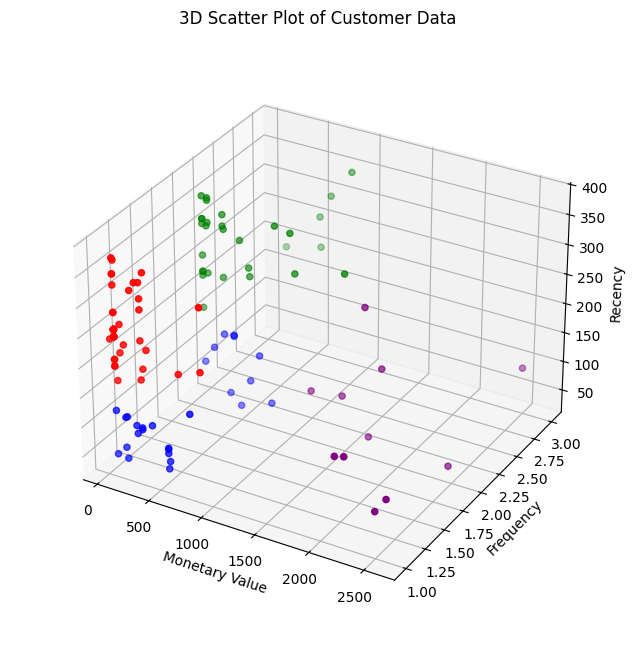

In [312]:
cluster_colors = {0: 'green',
                  1: 'purple',
                  2: 'red',
                  3: 'blue',
                  }

colors = non_outliers_df['Cluster'].map(cluster_colors)

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(projection="3d")

scatter = ax.scatter(non_outliers_df["MonetaryValue"],
                     non_outliers_df["Frequency"],
                     non_outliers_df["Recency"],
                     c=colors,
                     marker='o')

ax.set_xlabel("Monetary Value")
ax.set_ylabel("Frequency")
ax.set_zlabel("Recency")

ax.set_title("3D Scatter Plot of Customer Data")
ax.set_box_aspect(None, zoom=0.90)
plt.show()

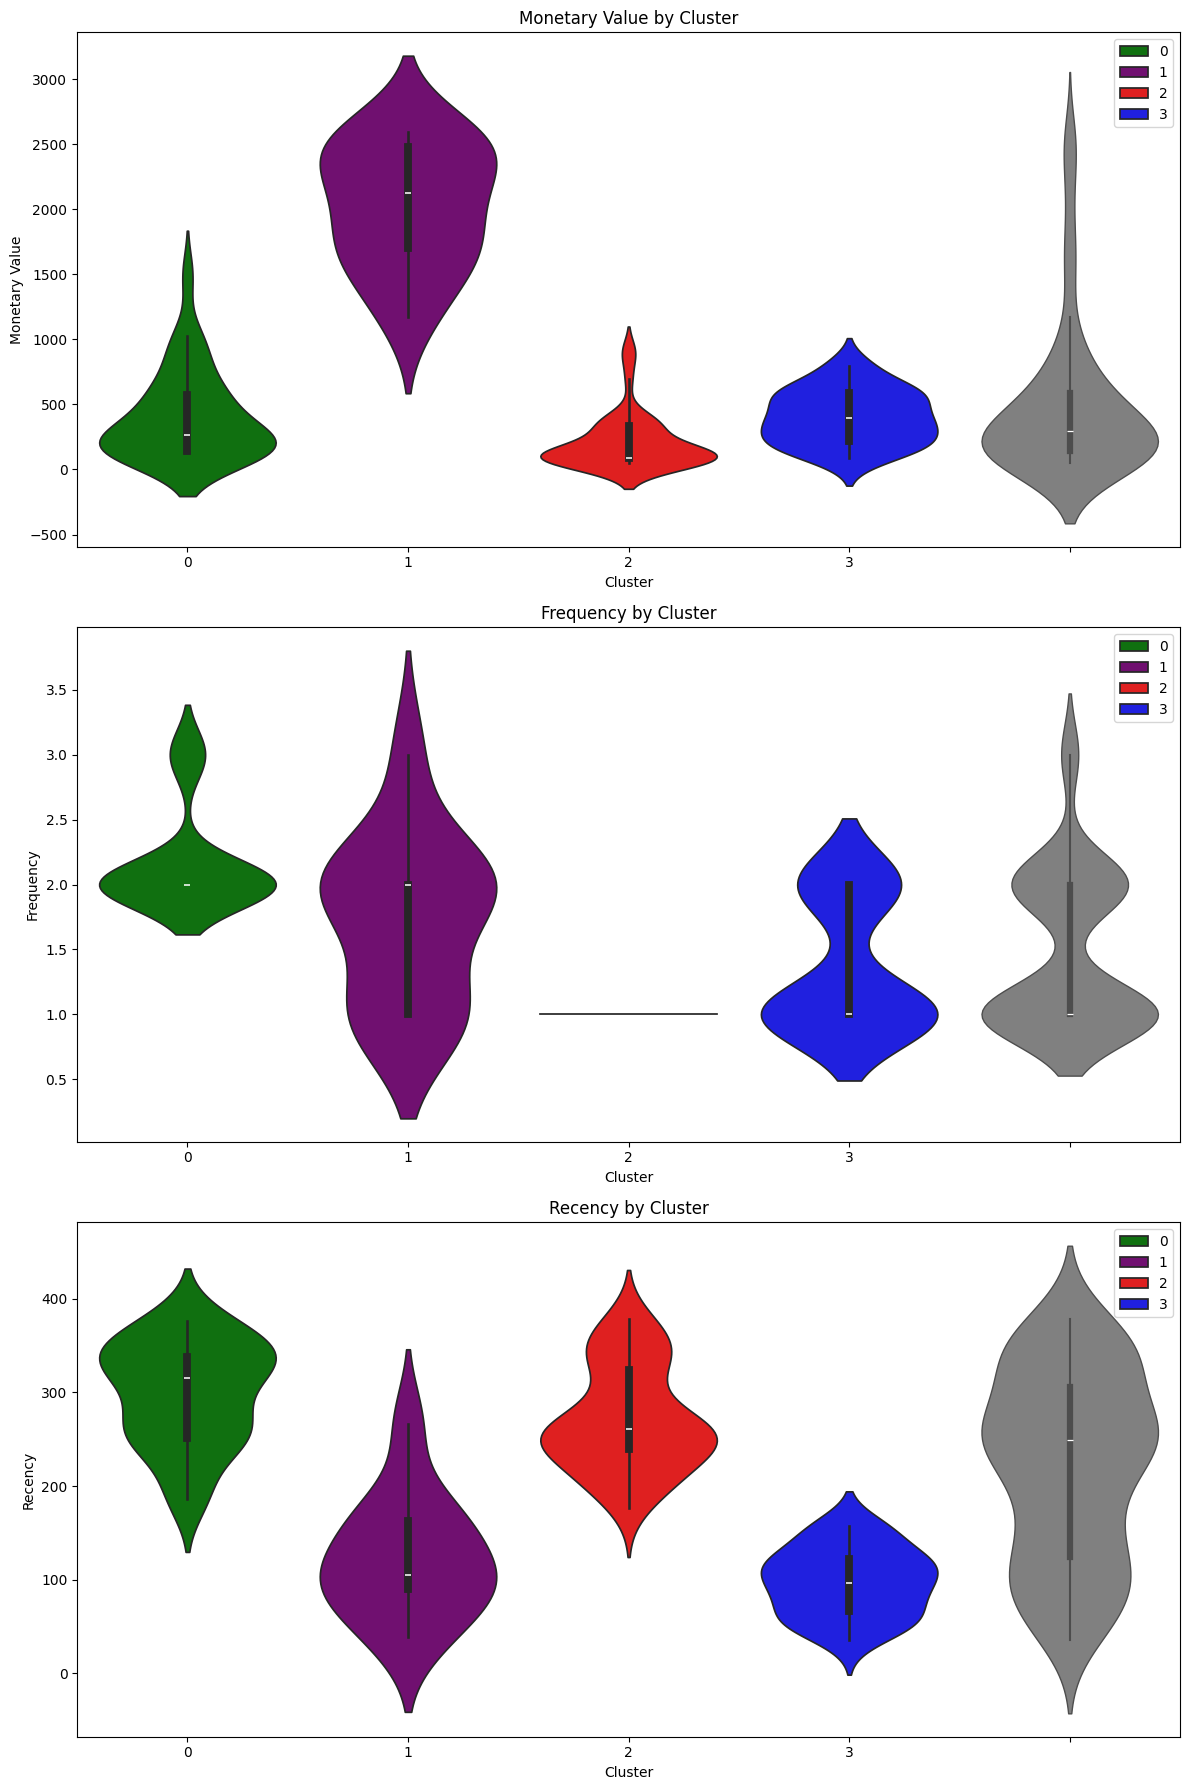

In [313]:
plt.figure(figsize=(12, 18))

plt.subplot(3, 1, 1)
sns.violinplot(x=non_outliers_df["Cluster"], y=non_outliers_df["MonetaryValue"], palette=cluster_colors, hue=non_outliers_df["Cluster"])
sns.violinplot(y=non_outliers_df["MonetaryValue"], color='grey', linewidth=1.0)
plt.title("Monetary Value by Cluster")
plt.ylabel("Monetary Value")

plt.subplot(3, 1, 2)
sns.violinplot(x=non_outliers_df["Cluster"], y=non_outliers_df["Frequency"], palette=cluster_colors, hue=non_outliers_df["Cluster"])
sns.violinplot(y=non_outliers_df["Frequency"], color='grey', linewidth=1.0)
plt.title("Frequency by Cluster")
plt.ylabel("Frequency")

plt.subplot(3, 1, 3)
sns.violinplot(x=non_outliers_df["Cluster"], y=non_outliers_df["Recency"], palette=cluster_colors, hue=non_outliers_df["Cluster"])
sns.violinplot(y=non_outliers_df["Recency"], color='grey', linewidth=1.0)
plt.title("Recency by Cluster")
plt.ylabel("Recency")

plt.tight_layout()
plt.show()

### **6.2. Defining Customer Personas**
Along with the previous plots, I will calculate their median RFM values which allows me to create a clear persona for each segment, which helps guide tailored business strategies.

In [314]:
cluster_profiles = non_outliers_df.groupby('Cluster')[['MonetaryValue', 'Frequency', 'Recency']].median()
cluster_profiles

,MonetaryValue,Frequency,Recency
Cluster,,,
0,262.50,2.00,315.50
1,2125.00,2.00,105.00
2,90.00,1.00,261.00
3,395.00,1.00,97.00


#### **Cluster 0 (Green): "Retain"**

* **Breakdown:** These customers also have a **high Recency** and **low Frequency**. They represent a **lapsed** segment with a history of engagement, but they may have a slightly higher MonetaryValue than other lapsed groups.

* **Goal:** **Retain.** They have a history of engagement and value, so the goal is to bring them back through targeted offers or discounts to prevent them from becoming dormant.

#### **Cluster 1 (Purple): "Reward"**

* **Breakdown:** These customers have an **extremely high MonetaryValue** and a **low Recency**, indicating they are very recent and high-spending. This makes them my **most loyal and valuable clients**.

* **Goal:** **Reward.** Provide them with exclusive loyalty programs, VIP offers, and personalized communication to ensure they feel appreciated and remain engaged, maximizing their lifetime value.

#### **Cluster 2 (Red): "Re-Engage"**

* **Breakdown:** These customers were active in the past but have since become **inactive**, with a **high Recency** value. They have a low frequency and low to mid-range total spend, indicating they have become **dormant**.

* **Goal:** **Re-Engage.** Bring them back through targeted email campaigns or special "comeback" discounts to encourage another purchase.

#### **Cluster 3 (Blue): "Nurture"**

* **Breakdown:** These customers are **new to the business**. They have a **low Recency** (a recent purchase), but are typically **one-time purchasers** so far. They currently have the lowest total spend but represent potential future value.

* **Goal:** **Nurture.** Build a relationship and provide incentives to encourage them to become repeat customers and build loyalty, preventing them from becoming a lapsed client.

### **Summary of Cluster Names**
* Cluster 0 (Green): "Retain"
* Cluster 1 (Purple): "Reward"
* Cluster 2 (Red): "Re-Engage"
* Cluster 3 (Blue): "Nurture"

## **7. Outlier Analysis**

After isolating outliers from my core dataset, I performed a dedicated analysis on these data points to understand their unique characteristics. This is a crucial step, as outliers are often not errors but represent significant customer behaviors that can provide high-value insights.


### **7.1. Categorization of Outliers**

I categorized the outliers into three distinct groups based on which RFM dimensions contained the extreme values:

* **MonetaryValue Outliers:** Customers with an exceptionally high total spend.
* **Frequency Outliers:** Customers with an exceptionally high number of purchases.
* **Combined Outliers:** Customers who are outliers in **both** MonetaryValue and Frequency.


In [315]:
overlap_indices = MV_outliers_df.index.intersection(F_outliers_df.index) # Includes the outliers in both MV and F DataFrames
MV_only_outliers = MV_outliers_df.drop(overlap_indices) # Includes ONLY the outliers in the MV DataFrames
F_only_outliers = F_outliers_df.drop(overlap_indices) # Includes ONLY the outliers in the F DataFrames
MV_and_F_outliers = MV_outliers_df.loc[overlap_indices] # Includes ONLY the outliers in both MV and F DataFrames

MV_only_outliers["Cluster"] = -1
F_only_outliers["Cluster"] = -2
MV_and_F_outliers["Cluster"] = -3

outlier_clusters_df = pd.concat([MV_only_outliers, F_only_outliers, MV_and_F_outliers])

outlier_clusters_df.head()

,CUSTOMER_ID,MonetaryValue,Frequency,LastInvoiceDate,Recency,Cluster
2,CUST_0003,4920.00,1,2024-02-15,345,-1
23,CUST_0024,3675.00,3,2024-09-27,120,-1
38,CUST_0039,4690.00,2,2024-12-09,47,-1
62,CUST_0063,7720.00,1,2024-10-18,99,-1
71,CUST_0072,4155.00,1,2024-03-06,325,-1


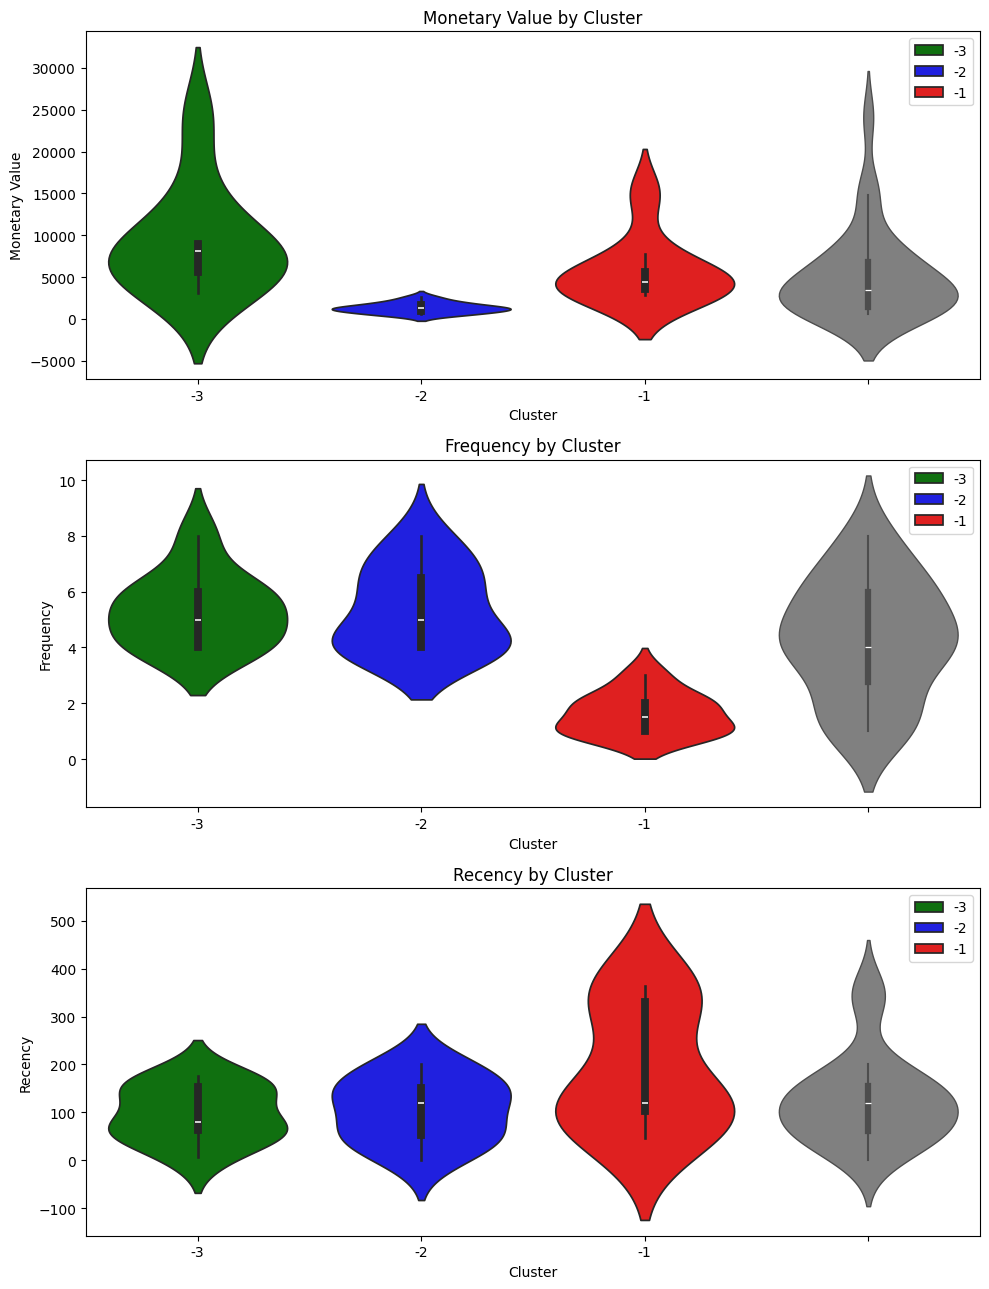

In [316]:
cluster_colors = {-1: 'red',
                  -2: 'blue',
                  -3: 'green'}

plt.figure(figsize=(10, 13))

plt.subplot(3, 1, 1)
sns.violinplot(x=outlier_clusters_df["Cluster"], y=outlier_clusters_df["MonetaryValue"], palette=cluster_colors, hue=outlier_clusters_df["Cluster"])
sns.violinplot(y=outlier_clusters_df["MonetaryValue"], color='grey', linewidth=1.0)
plt.title("Monetary Value by Cluster")
plt.ylabel("Monetary Value")

plt.subplot(3, 1, 2)
sns.violinplot(x=outlier_clusters_df["Cluster"], y=outlier_clusters_df["Frequency"], palette=cluster_colors, hue=outlier_clusters_df["Cluster"])
sns.violinplot(y=outlier_clusters_df["Frequency"], color='grey', linewidth=1.0)
plt.title("Frequency by Cluster")
plt.ylabel("Frequency")

plt.subplot(3, 1, 3)
sns.violinplot(x=outlier_clusters_df["Cluster"], y=outlier_clusters_df["Recency"], palette=cluster_colors, hue=outlier_clusters_df["Cluster"])
sns.violinplot(y=outlier_clusters_df["Recency"], color='grey', linewidth=1.0)
plt.title("Recency by Cluster")
plt.ylabel("Recency")

plt.tight_layout()
plt.show()


### **7.2. Profiling the Outlier Segments**

See 6.2 above


In [317]:
# Calculates the median values of each cluster for each RFM metric
outlier_cluster_profiles = outlier_clusters_df.groupby('Cluster')[['MonetaryValue', 'Frequency', 'Recency']].median()
outlier_cluster_profiles

,MonetaryValue,Frequency,Recency
Cluster,,,
-3,8170.00,5.00,79.00
-2,1240.00,5.00,119.00
-1,4422.50,1.50,120.50


#### Cluster -3 (Green): "Appreciate"

* **Breakdown:** These customers are the most valuable outliers, defined by their exceptionally **high total spend** and **high purchase frequency**. They are the top-tier clients and the most loyal customers in the dataset.

* **Goal: Appreciate.** Maximize their lifetime value by providing special attention, exclusive offers, and VIP communication to ensure their continued loyalty and prevent them from switching to a competitor.

#### Cluster -2 (Blue): "Upsell"

* **Breakdown:** These customers are very active and purchase frequently, but they have a **lower average spend per purchase**.

* **Goal: Upsell.** Encourage them to increase their average transaction amount. This could be achieved by promoting higher-tier services or offering bundled packages and bulk deals to increase their spend per purchase.

#### Cluster -1 (Red): "Spoil"

* **Breakdown:** These customers spend a lot but are **infrequent buyers**, making them a high-value but low-frequency segment.

* **Goal: Spoil.** Bring them back for another high-value purchase. This could be done by offering them exclusive, one-time opportunities or showcasing new luxury services to entice them to engage again.

### **Summary of Cluster Names**

* Cluster -3 (Green): "Appreciate"
* Cluster -2 (Blue): "Upsell"
* Cluster -1 (Red): "Spoil"

In [318]:
cluster_labels = {
  0: "RETAIN",
  1: "REWARD",
  2: "RE-ENGAGE",
  3: "NURTURE",
  -1: "SPOIL",
  -2: "UPSELL",
  -3: "APPRECIATE"
}

In [319]:
full_clustering_df = pd.concat([non_outliers_df, outlier_clusters_df]) # Complete data that includes both outliers and base data

full_clustering_df['ClusterLabel'] = full_clustering_df["Cluster"].map(cluster_labels)

full_clustering_df.head()

,CUSTOMER_ID,MonetaryValue,Frequency,LastInvoiceDate,Recency,Cluster,ClusterLabel
0,CUST_0001,1490.00,2,2024-03-19,312,0,RETAIN
1,CUST_0002,190.00,3,2024-07-23,186,0,RETAIN
3,CUST_0004,1175.00,2,2024-10-19,98,1,REWARD
4,CUST_0005,2490.00,1,2024-10-27,90,1,REWARD
5,CUST_0006,585.00,1,2024-10-29,88,3,NURTURE


## **8. Visualization**

In this section, I will visualize my final customer segments to communicate my findings and bring the clusters to life for stakeholders.

I created a combined bar and line chart to provide a clear summary of each cluster's performance across my key RFM metrics. This chart offers a simple, powerful overview of my customer segments, allowing for quick comparisons of their average Recency, Frequency, and Monetary Value at a glance.

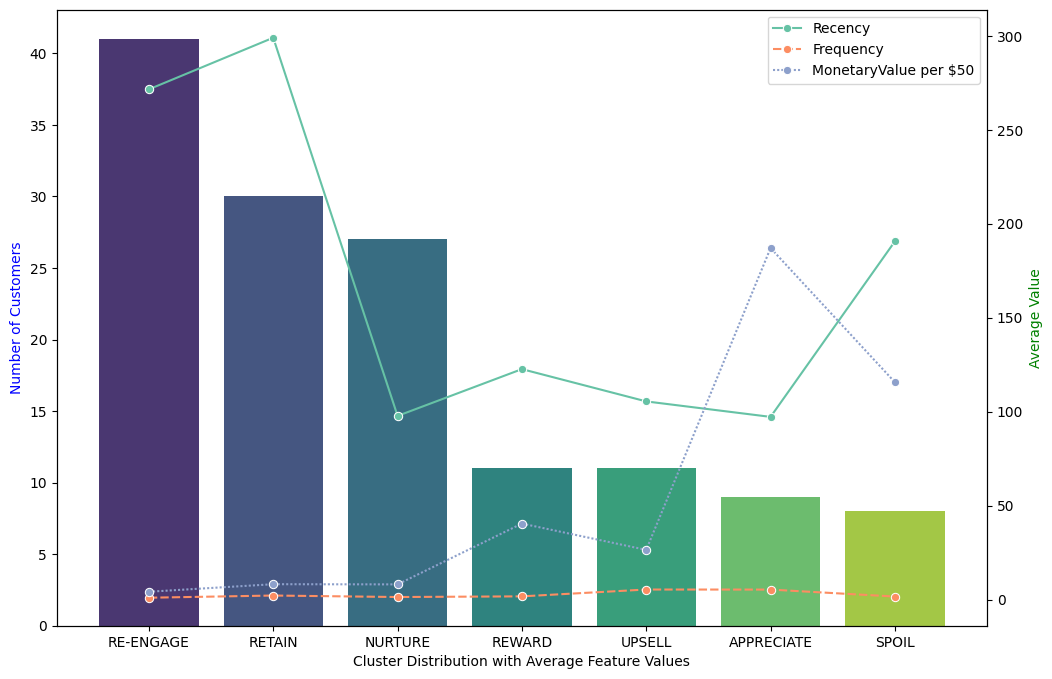

In [320]:
cluster_counts = full_clustering_df['ClusterLabel'].value_counts()
full_clustering_df["MonetaryValue per $50"] = full_clustering_df['MonetaryValue'] / 50.00
feature_means = full_clustering_df.groupby('ClusterLabel')[['Recency', 'Frequency', 'MonetaryValue per $50']].mean()

fig, ax1 = plt.subplots(figsize=(12,8))

sns.barplot(x=cluster_counts.index, y= cluster_counts.values, ax=ax1, palette='viridis', hue=cluster_counts.index)
ax1.set_ylabel('Number of Customers', color='b')
ax1.set_xlabel('Cluster Distribution with Average Feature Values')

ax2 = ax1.twinx()

sns.lineplot(data=feature_means, ax=ax2, palette='Set2', marker='o')
ax2.set_ylabel('Average Value', color='g')

plt.show()

## **9. Conclusion & Business Recommendations**

Based on my analysis, I successfully identified four distinct customer segments, each with a unique profile and associated business opportunities. This segmentation provides a clear framework for developing targeted strategies.

Here are my actionable recommendations for the business owner:

* **For the "Re-Engage" cluster:** These are lapsed customers who were once engaged. I recommend running a targeted re-engagement campaign with compelling "welcome back" offers to bring them back into the active customer base.

* **For the "Retain" cluster:** These clients have a history of engagement but have become inactive. I recommend a personalized outreach to understand their needs and offer a discount on their next purchase.

* **For the "Nurture" cluster:** This segment consists of new customers who have made a recent purchase. I recommend building a strong relationship through exceptional customer service and follow-up incentives to encourage a second purchase, which is a key driver of long-term loyalty.

* **For the "Reward" cluster:** This is my highest-value, most loyal customer base. I recommend providing them with exclusive access to new services, loyalty rewards, or personalized offers to maximize their lifetime value and encourage referrals.


## **10. Possible Next Steps**

This project lays a strong foundation for future data analysis. The next logical steps could include:

* **Customer Lifetime Value (CLTV) Prediction:** Using the RFM data, a predictive model could be built to forecast the total revenue a customer will generate, allowing for more strategic marketing spend.

* **Service Recommendation Engine:** Using the itemized service data, an algorithm could be developed to recommend add-on services or bundles based on a customer's past purchases.

* **Profitability Analysis:** Integrating cost data (e.g., from vendor invoices, advertising spend) to analyze the profitability of each customer segment or service type.